In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np


def one_hot_encoder(training_path, val_path, test_path):
    # Get training data from files
    training_data = []
    decoder_input = []
    decoder_output = []
    with open(training_path, encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            # Separate Chinese and English, line[0] is the English sentence and line[1] is the translated Chinese
            line = line.split(' 	')
            line[0] += '[EOS]'
            line[0] = '[BOS] ' + line[0]

            decoder_input.append('[BOS] '+line[1])
            decoder_output.append(line[1] + '[EOS]')

            line[1] += '[EOS]'
            line[1] = '[BOS] ' + line[1]
            training_data.append(line)

    train_sz = len(training_data)
    training_data = np.array(training_data)

    # Build English one-hot encoder
    max_eng_vocabulary = 10000
    max_eng_sentence_length = 50

    eng_vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
        max_tokens=max_eng_vocabulary,
        output_mode='int',
        output_sequence_length=max_eng_sentence_length,
        pad_to_max_tokens=True
    )
    eng_vectorize_layer.adapt(training_data[:, 0])
    eng_vocabulary = eng_vectorize_layer.get_vocabulary()
    print(eng_vocabulary[:20])

    train_text = eng_vectorize_layer(training_data[:, 0])

    # Build Chinese one-hot encoder
    max_chi_vocabulary = 10000
    max_chi_sentence_length = 50

    chi_vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
        max_tokens=max_chi_vocabulary,
        output_mode='int',
        output_sequence_length=max_chi_sentence_length,
        pad_to_max_tokens=True
    )
    chi_vectorize_layer.adapt(training_data[:, 1])
    chi_vocabulary = chi_vectorize_layer.get_vocabulary()
    print(chi_vocabulary[:20])

    train_label = chi_vectorize_layer(training_data[:, 1])
    decoder_input = chi_vectorize_layer(decoder_input)
    decoder_output = chi_vectorize_layer(decoder_output)

    # Create training dataset
    train_ds = tf.data.Dataset.from_tensor_slices((train_text, train_label))
    train_ds = train_ds.shuffle(buffer_size=train_sz)

    # Get validation dataset from files
    val_data = []
    with open(val_path, encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            # Separate Chinese and English, line[0] is the English sentence and line[1] is the translated Chinese
            line = line.split(' 	')
            line[0] += '[EOS]'
            line[0] = '[BOS] ' + line[0]
            line[1] += '[EOS]'
            line[1] = '[BOS] ' + line[1]
            val_data.append(line)

    val_sz = len(val_data)
    val_data = np.array(val_data)

    val_text = eng_vectorize_layer(val_data[:, 0])
    val_label = chi_vectorize_layer(val_data[:, 1])

    val_ds = tf.data.Dataset.from_tensor_slices((val_text, val_label))

    # Get test dataset from files
    test_data = []
    with open(test_path, encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            # Separate Chinese and English, line[0] is the English sentence and line[1] is the translated Chinese
            line = line.split(' 	')
            line[0] += '[EOS]'
            line[0] = '[BOS] ' + line[0]
            line[1] += '[EOS]'
            line[1] = '[BOS] ' + line[1]
            test_data.append(line)

    test_sz = len(test_data)
    test_data = np.array(test_data)

    test_text = eng_vectorize_layer(test_data[:, 0])
    test_label = chi_vectorize_layer(test_data[:, 1])

    test_ds = tf.data.Dataset.from_tensor_slices((test_text, test_label))

    # Batch training dataset and validation dataset
    batch_sz = 64
    train_ds = train_ds.batch(batch_sz)
    val_ds = val_ds.batch(batch_sz)
    test_ds = test_ds.batch(batch_sz)

    encoder_input = train_text

    return train_ds, val_ds, test_ds, eng_vocabulary, chi_vocabulary, encoder_input, decoder_input, decoder_output




In [3]:
training_path = '/content/drive/MyDrive/seq2seq/training.txt'
val_path = '/content/drive/MyDrive/seq2seq/validation.txt'
test_path = '/content/drive/MyDrive/seq2seq/testing.txt'

['', '[UNK]', 'eos', 'bos', 'i', 'the', 'to', 'you', 'a', 'is', 'he', 'nt', 'tom', 'do', 'it', 's', 'in', 'of', 'my', 'she']
['', '[UNK]', 'eos', 'bos', '。', '我', '的', '了', '你', '他', '？', '在', '是', '她', '湯姆', '嗎', '我們', '，', '不', '有']


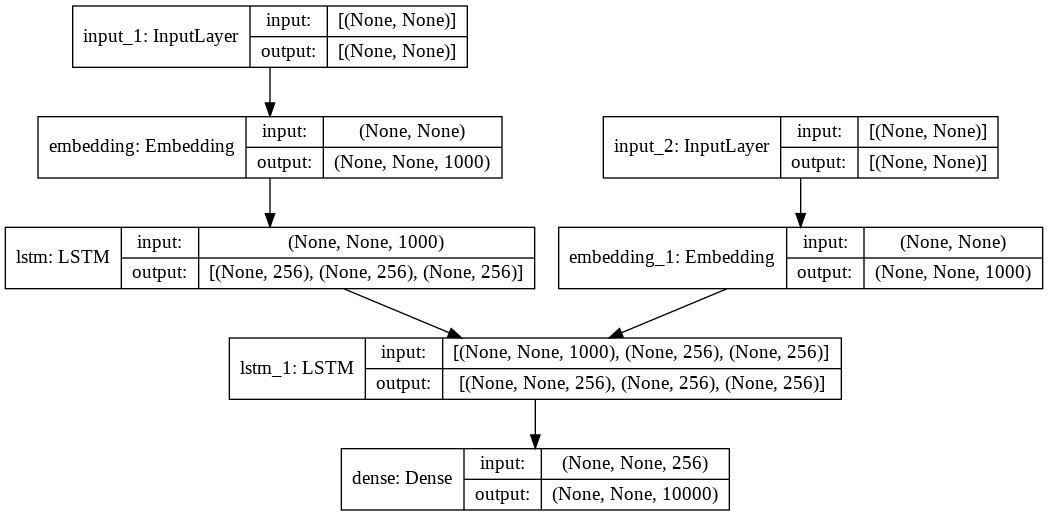

In [4]:
train_ds, val_ds, test_ds, eng_vocabulary, chi_vocabulary, \
encoder_input_data, decoder_input_data, decoder_output_data = one_hot_encoder(training_path, val_path, test_path)

max_chi_vocabulary = 10000
max_chi_sentence_length = 50
max_eng_vocabulary = 10000
max_eng_sentence_length = 50

# Build encoder model
embedding_output_length = 1000
encoder_output_length = 50

encoder_input = tf.keras.Input(shape=(None,))
encoder_embedding = tf.keras.layers.Embedding(
    input_dim=max_eng_vocabulary,
    output_dim=embedding_output_length,
    mask_zero=True,
)
encoder_input_1 = encoder_embedding(encoder_input)
encoder_lstm = tf.keras.layers.LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_input_1)
encoder_states = [state_h, state_c]

# Build decoder model
decoder_input = tf.keras.Input(shape=(None,))
decoder_embedding = tf.keras.layers.Embedding(
    input_dim=max_chi_vocabulary,
    output_dim=embedding_output_length,
    mask_zero=True,
)
decoder_input_1 = decoder_embedding(decoder_input)
decoder_lstm = tf.keras.layers.LSTM(
    256,
    return_state=True,
    return_sequences=True,
)
decoder_outputs, _, _ = decoder_lstm(decoder_input_1, initial_state=encoder_states)
decoder_dense = tf.keras.layers.Dense(max_chi_vocabulary, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Combine encoder and decoder
model = tf.keras.Model([encoder_input, decoder_input], decoder_outputs)
tf.keras.utils.plot_model(model, show_shapes=True)

In [5]:
# Train model
batch_sz = 64
epochs = 100

model.compile(optimizer='rmsprop', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
model.fit([encoder_input_data, decoder_input_data], decoder_output_data,
          batch_size=batch_sz,
          epochs=epochs)

Epoch 1/100
282/282 [==============================] - 40s 115ms/step - loss: 0.8595 - accuracy: 0.2426
Epoch 2/100
282/282 [==============================] - 32s 114ms/step - loss: 0.6710 - accuracy: 0.3764
Epoch 3/100
282/282 [==============================] - 32s 114ms/step - loss: 0.5961 - accuracy: 0.4360
Epoch 4/100
282/282 [==============================] - 32s 114ms/step - loss: 0.5460 - accuracy: 0.4701
Epoch 5/100
282/282 [==============================] - 32s 114ms/step - loss: 0.5046 - accuracy: 0.5027
Epoch 6/100
282/282 [==============================] - 32s 114ms/step - loss: 0.4658 - accuracy: 0.5351
Epoch 7/100
282/282 [==============================] - 32s 114ms/step - loss: 0.4267 - accuracy: 0.5679
Epoch 8/100
282/282 [==============================] - 32s 114ms/step - loss: 0.4019 - accuracy: 0.5913
Epoch 9/100
282/282 [==============================] - 32s 114ms/step - loss: 0.3730 - accuracy: 0.6192
Epoch 10/100
282/282 [==============================] - 32s 114m

In [6]:
model.save("/content/drive/MyDrive/seq2seq/teacher_forcing.h5")

In [19]:
for input_val, output_val in train_ds:
  trail_val_input = input_val[:20, :]
  trail_val_output = output_val[:20, :]
  break


In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 1000)   10000000    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 1000)   10000000    input_2[0][0]                    
______________________________________________________________________________________________

In [33]:
for i in range(20):
    original = ''
    x = input_val[i, :]
    for i, xx in enumerate(x):
      xx = eng_vocabulary[xx]
      if xx != 'eos' and xx != 'bos':
        original += (xx + ' ')
    x = tf.reshape(x, (1, 50))

    y = [3]
    y = tf.reshape(y, (1, 1))

    stop_condition = False
    pred_word = ''
    last_index = 3
    time_step = 0
    while not stop_condition:
      model.reset_states()
      output = model.predict([x, y])
      max_index = np.argmax(output[0, time_step, :])
      new_pred = chi_vocabulary[max_index]
      if new_pred != 'eos':
        pred_word += new_pred
      y = tf.concat((y, tf.reshape([max_index], [1, 1])), axis=-1)
      
      time_step += 1

      if new_pred == 'eos' or y.shape[-1] >= 50:
        stop_condition = True

    print('English: '+ original + '\n' + 'Chinese: ' + pred_word)


English: what do i have to do now that i m registered                                      
Chinese: 我
English: what time does the movie start                                           
Chinese: 電影什麼時候開始？
English: i ve lost my watch                                            
Chinese: 我把我的表丟了。
English: i have nt started anything yet                                           
Chinese: 我還沒開始做任何事。
English: i am counting on you                                            
Chinese: 我指望你了。
English: both of her sons died during the war                                         
Chinese: 她的孩子都死於讓我的人。
English: i thought you said something                                            
Chinese: 我覺得你說了什麼。
English: there were some bo a ts on the lake                                        
Chinese: 湖上有一些船。
English: we were nt at home yesterday evening                                          
Chinese: 昨天晚上我們不在家。
English: i ve got no friends                                            
Chinese: 我沒有朋友。
Eng